In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class MLP(nn.Module):

    def __init__(self, act_fn, num_inputs, hidden_layers, num_hidden, num_outputs):
        super().__init__()
        self.dropout_input = nn.Dropout(0.8)
        self.hidden_layers = hidden_layers
        self.layers = nn.ModuleList()
        self.act_fns = nn.ModuleList()

        # Create hidden layers and activation functions
        for _ in range(hidden_layers):
            self.layers.append(nn.Linear(num_inputs, num_hidden))
            self.act_fns.append(act_fn)
            num_inputs = num_hidden

        self.output = nn.Linear(num_hidden, num_outputs)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)
        x = self.dropout_input(x)
        for layer, act_fn in zip(self.layers, self.act_fns):
            x = act_fn(layer(x))
            x = self.dropout(x)
        x = self.output(x)
        return x


class ad_dr_MLP(nn.Module):

    def __init__(self, act_fn, num_inputs, hidden_layers, num_hidden, num_outputs, dropout_start=0.5, dropout_end=0.1, total_epochs=10):
        super().__init__()
        self.dropout_input = nn.Dropout(0.8)
        self.hidden_layers = hidden_layers
        self.layers = nn.ModuleList()
        self.act_fns = nn.ModuleList()

        # Create hidden layers and activation functions
        for _ in range(hidden_layers):
            self.layers.append(nn.Linear(num_inputs, num_hidden))
            self.act_fns.append(act_fn)
            num_inputs = num_hidden

        self.output = nn.Linear(num_hidden, num_outputs)
        self.dropout_start = dropout_start
        self.dropout_end = dropout_end
        self.total_epochs = total_epochs

    def forward(self, x, epoch):
        # Flatten the input
        x = x.view(x.size(0), -1)
        x = self.dropout_input(x)
        for layer, act_fn in zip(self.layers, self.act_fns):
            x = act_fn(layer(x))
            x = self.dynamic_dropout(x, epoch)
        x = self.output(x)
        return x

    def dynamic_dropout(self, x, epoch):
        p = self.get_dropout_rate(epoch)
        return F.dropout(x, p=p, training=self.training)

    def get_dropout_rate(self, epoch):
        if self.dropout_start > self.dropout_end:
          return self.dropout_start - (self.dropout_start - self.dropout_end) * ((epoch-1) / (self.total_epochs-1))
        else:
          return self.dropout_start + (self.dropout_end - self.dropout_start) * ((epoch-1) / (self.total_epochs-1))


# Compre with MNIST dataset

In [3]:
# @title MNIST dataset
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Print sizes and dimensions
print(f"Training set size: {len(train_dataset)} samples")
print(f"Test set size: {len(test_dataset)} samples")

# Print number of columns (features) in the dataset
num_features = train_dataset.data.shape[1] * train_dataset.data.shape[2]
print(f"Number of columns (features): {num_features}")
# Print number of classes in the dataset
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14335987.47it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 508170.68it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3795987.91it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9207602.11it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training set size: 60000 samples
Test set size: 10000 samples
Number of columns (features): 784
Number of classes: 10


In [4]:
# @title Max norm function
# Weight constraint function
def apply_weight_constraints(model, c):
    with torch.no_grad():
        for param in model.parameters():
            param.clamp_(-c, c)

In [5]:
# @title Train and test function
# Training loop
def train(model, train_loader, optimizer, criterion, epoch, ad_dr=False):
    model.train()
    correct = 0
    total = 0
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # Move tensors to GPU
        optimizer.zero_grad()
        if ad_dr:
                output = model(data, epoch)
        else:
                output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if "max_norm" in str(model):
            print("applaied max norm constraints")
            apply_weight_constraints(model, c=2)
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

        if batch_idx % 100 == 0:
            if ad_dr:
                print("Dropout rate: ", model.get_dropout_rate(epoch))
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    if model.__class__.__name__ == "ad_dr_MLP" and model.dropout_start>model.dropout_end:
              train_losses_ad_des_dr.append(avg_loss)
              train_accuracies_ad_des_dr.append(accuracy)
    elif model.__class__.__name__ == "ad_dr_MLP" and model.dropout_start<model.dropout_end:
              train_losses_ad_asc_dr.append(avg_loss)
              train_accuracies_ad_asc_dr.append(accuracy)
    else:
              train_losses.append(avg_loss)
              train_accuracies.append(accuracy)

# Testing loop
def test(model, test_loader, criterion, ad_dr=False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)  # Move tensors to GPU
            if ad_dr:
                output = model(data, epoch)
            else:
                output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    if model.__class__.__name__ == "ad_dr_MLP" and model.dropout_start>model.dropout_end:
              test_losses_ad_des_dr.append(test_loss)
              test_accuracies_ad_des_dr.append(accuracy)
    elif model.__class__.__name__ == "ad_dr_MLP" and model.dropout_start<model.dropout_end:
              test_losses_ad_asc_dr.append(test_loss)
              test_accuracies_ad_asc_dr.append(accuracy)
    else:
              test_losses.append(test_loss)
              test_accuracies.append(accuracy)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')

In [5]:
# @title Train and test function
# Training loop
def train(model, train_loader, optimizer, criterion, epoch, ad_dr=False):
    model.train()
    correct = 0
    total = 0
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # Move tensors to GPU
        optimizer.zero_grad()
        if ad_dr:
            output = model(data, epoch)
        else:
            output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if "max_norm" in str(model):
            print("applaied max norm constraints")
            apply_weight_constraints(model, c=2)
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

        if batch_idx % 100 == 0:
            if ad_dr:
                print("Dropout rate: ", model.get_dropout_rate(epoch))
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    avg_loss = total_loss / len(train_loader)
    error = 1 - (correct / total)
    if model.__class__.__name__ == "ad_dr_MLP" and model.dropout_start > model.dropout_end:
        train_losses_ad_des_dr.append(avg_loss)
        train_errors_ad_des_dr.append(error)
    elif model.__class__.__name__ == "ad_dr_MLP" and model.dropout_start < model.dropout_end:
        train_losses_ad_asc_dr.append(avg_loss)
        train_errors_ad_asc_dr.append(error)
    else:
        train_losses.append(avg_loss)
        train_errors.append(error)

# Testing loop
def test(model, test_loader, criterion, ad_dr=False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)  # Move tensors to GPU
            if ad_dr:
                output = model(data, epoch)
            else:
                output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    error = 1 - (correct / len(test_loader.dataset))
    if model.__class__.__name__ == "ad_dr_MLP" and model.dropout_start > model.dropout_end:
        test_losses_ad_des_dr.append(test_loss)
        test_errors_ad_des_dr.append(error)
    elif model.__class__.__name__ == "ad_dr_MLP" and model.dropout_start < model.dropout_end:
        test_losses_ad_asc_dr.append(test_loss)
        test_errors_ad_asc_dr.append(error)
    else:
        test_losses.append(test_loss)
        test_errors.append(error)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Error: {error:.2f}\n')

In [6]:
# @title Connect to GPU
# Check if CUDA (GPU) is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [7]:
# @title Compere dropout and addaptive droupout, MLP with Sigmoid
model = MLP(nn.Sigmoid(), num_inputs=num_features, hidden_layers=3, num_hidden=1024, num_outputs=num_classes).to(device)
ad_des_dr_model = ad_dr_MLP(nn.Sigmoid(), num_inputs=num_features, hidden_layers=3, num_hidden=1024, num_outputs=num_classes).to(device)
ad_asc_dr_model = ad_dr_MLP(nn.Sigmoid(), num_inputs=num_features, hidden_layers=3, num_hidden=1024, num_outputs=num_classes, dropout_start=0.1, dropout_end=0.5).to(device)

# Printing a module shows all its submodules
print(model)
print(ad_des_dr_model)
print(ad_asc_dr_model)

loss_module=nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)
optimizer_ad_des_dr = optim.SGD(ad_des_dr_model.parameters(), lr=0.01, momentum=0.95)
optimizer_ad_asc_dr = optim.SGD(ad_asc_dr_model.parameters(), lr=0.01, momentum=0.95)

MLP(
  (dropout_input): Dropout(p=0.8, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1-2): 2 x Linear(in_features=1024, out_features=1024, bias=True)
  )
  (act_fns): ModuleList(
    (0-2): 3 x Sigmoid()
  )
  (output): Linear(in_features=1024, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
ad_dr_MLP(
  (dropout_input): Dropout(p=0.8, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1-2): 2 x Linear(in_features=1024, out_features=1024, bias=True)
  )
  (act_fns): ModuleList(
    (0-2): 3 x Sigmoid()
  )
  (output): Linear(in_features=1024, out_features=10, bias=True)
)
ad_dr_MLP(
  (dropout_input): Dropout(p=0.8, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1-2): 2 x Linear(in_features=1024, out_features=1024, bias=True)
  )
  (act_fns): ModuleList(
    (0-2): 3 x Sigmoid()
  )
  (o

In [8]:
# Lists to store training and test losses and errors
train_losses = []
test_losses = []
train_errors = []
test_errors = []

train_losses_ad_des_dr = []
test_losses_ad_des_dr = []
train_errors_ad_des_dr = []
test_errors_ad_des_dr = []

train_losses_ad_asc_dr = []
test_losses_ad_asc_dr = []
train_errors_ad_asc_dr = []
test_errors_ad_asc_dr = []


# Train and test the models
epochs = 10
for epoch in range(1, epochs + 1):
    train(model, trainloader, optimizer, loss_module, epoch)
    test(model, testloader, loss_module)

for epoch in range(1, epochs + 1):
    train(ad_des_dr_model, trainloader, optimizer_ad_des_dr, loss_module, epoch, ad_dr=True)
    test(ad_des_dr_model, testloader, loss_module, ad_dr=True)

for epoch in range(1, epochs + 1):
    train(ad_asc_dr_model, trainloader, optimizer_ad_asc_dr, loss_module, epoch, ad_dr=True)
    test(ad_asc_dr_model, testloader, loss_module, ad_dr=True)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.371001
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.447145
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.304178
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.312438
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.301273
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.267674
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.256279
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.020994
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.870458
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.572061

Test set: Average loss: 1.2733, Error: 0.46

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.488659
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.323864
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.346350
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.276448
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.103109
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.946745
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.854381
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.136971
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.925799
Train Epoch: 2 [

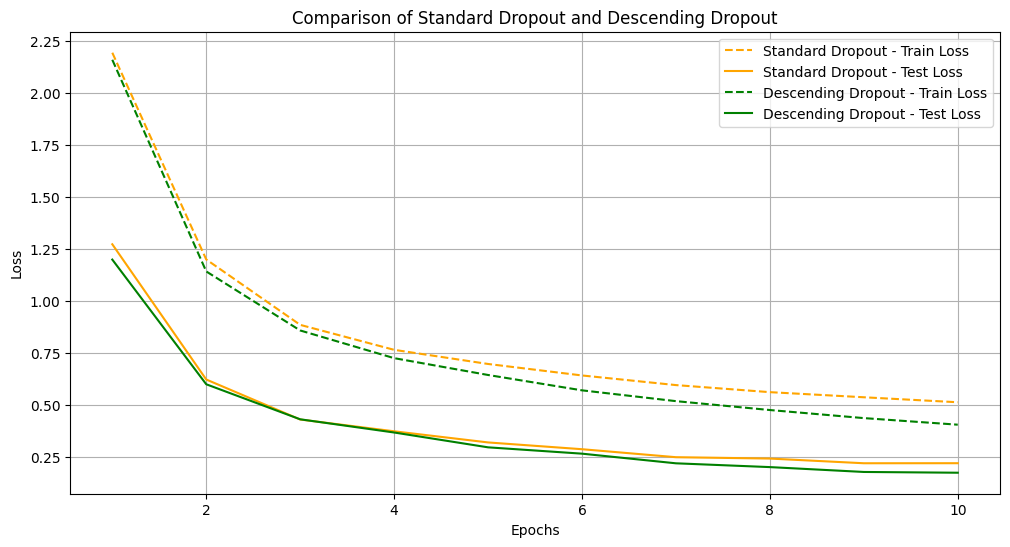

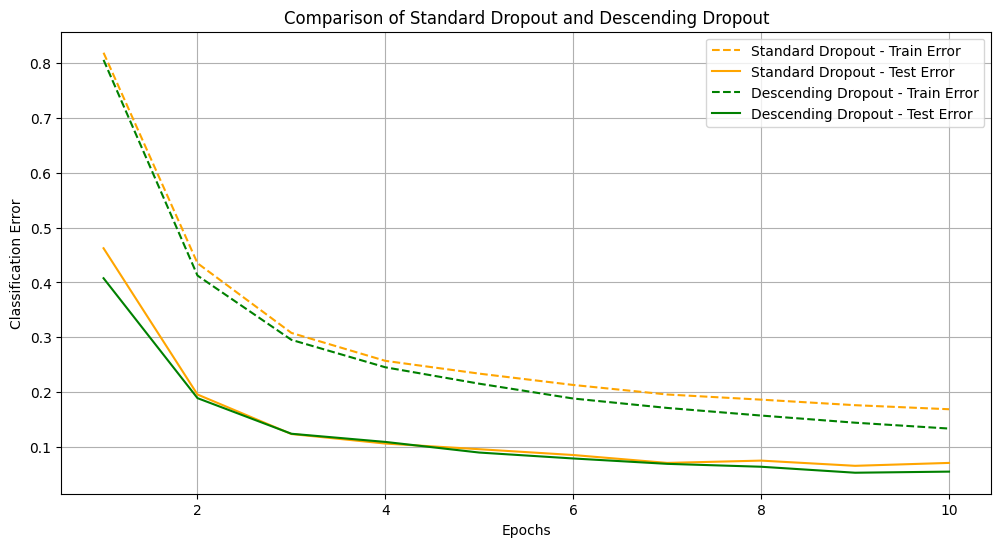

In [9]:
# @title Plots of droupout and desending droupout
# Plotting the training and test losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Standard Dropout - Train Loss', linestyle='--', color="orange")
plt.plot(range(1, epochs + 1), test_losses, label='Standard Dropout - Test Loss', color="orange")
plt.plot(range(1, epochs + 1), train_losses_ad_des_dr, label='Descending Dropout - Train Loss', linestyle='--', color="green")
plt.plot(range(1, epochs + 1), test_losses_ad_des_dr, label='Descending Dropout - Test Loss', color="green")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Standard Dropout and Descending Dropout')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the training and test errors
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_errors, label='Standard Dropout - Train Error', linestyle='--', color="orange")
plt.plot(range(1, epochs + 1), test_errors, label='Standard Dropout - Test Error', color="orange")
plt.plot(range(1, epochs + 1), train_errors_ad_des_dr, label='Descending Dropout - Train Error', linestyle='--', color="green")
plt.plot(range(1, epochs + 1), test_errors_ad_des_dr, label='Descending Dropout - Test Error', color="green")
plt.xlabel('Epochs')
plt.ylabel('Classification Error')
plt.title('Comparison of Standard Dropout and Descending Dropout')
plt.legend()
plt.grid(True)
plt.show()

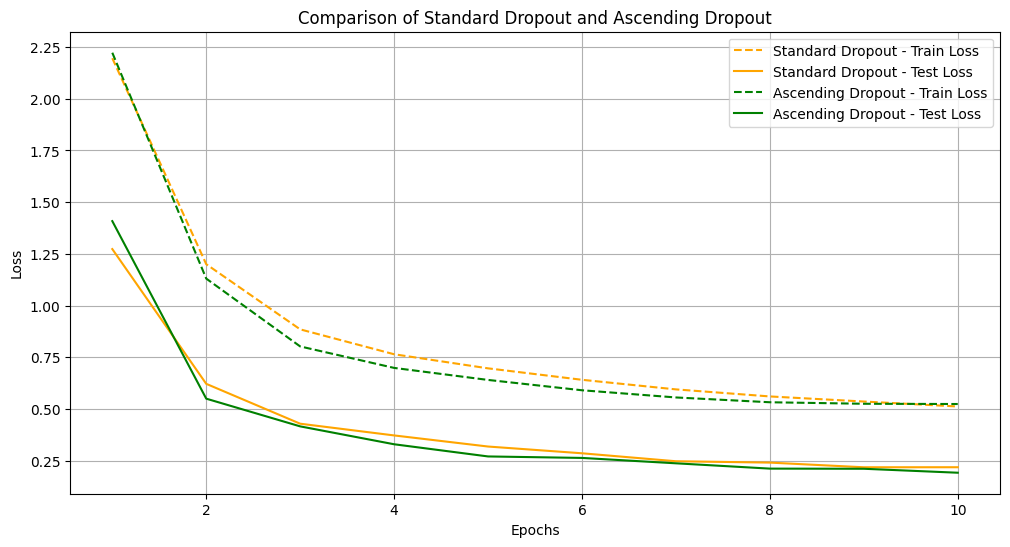

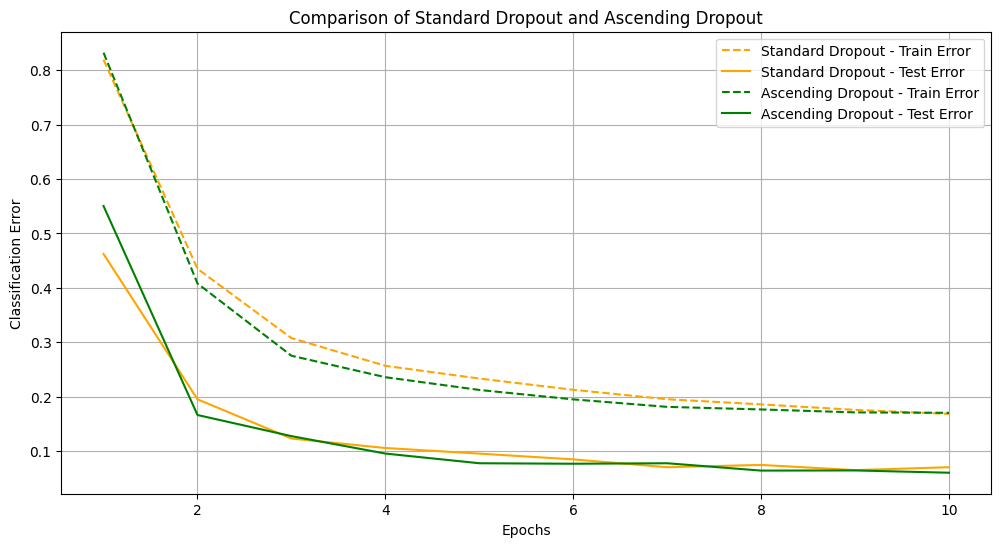

In [10]:
# @title Plots of droupout and ascending droupout
# Plotting the training and test losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Standard Dropout - Train Loss', linestyle='--', color="orange")
plt.plot(range(1, epochs + 1), test_losses, label='Standard Dropout - Test Loss', color="orange")
plt.plot(range(1, epochs + 1), train_losses_ad_asc_dr, label='Ascending Dropout - Train Loss', linestyle='--', color="green")
plt.plot(range(1, epochs + 1), test_losses_ad_asc_dr, label='Ascending Dropout - Test Loss', color="green")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Standard Dropout and Ascending Dropout')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the training and test errors
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_errors, label='Standard Dropout - Train Error', linestyle='--', color="orange")
plt.plot(range(1, epochs + 1), test_errors, label='Standard Dropout - Test Error', color="orange")
plt.plot(range(1, epochs + 1), train_errors_ad_asc_dr, label='Ascending Dropout - Train Error', linestyle='--', color="green")
plt.plot(range(1, epochs + 1), test_errors_ad_asc_dr, label='Ascending Dropout - Test Error', color="green")
plt.xlabel('Epochs')
plt.ylabel('Classification Error')
plt.title('Comparison of Standard Dropout and Ascending Dropout')
plt.legend()
plt.grid(True)
plt.show()


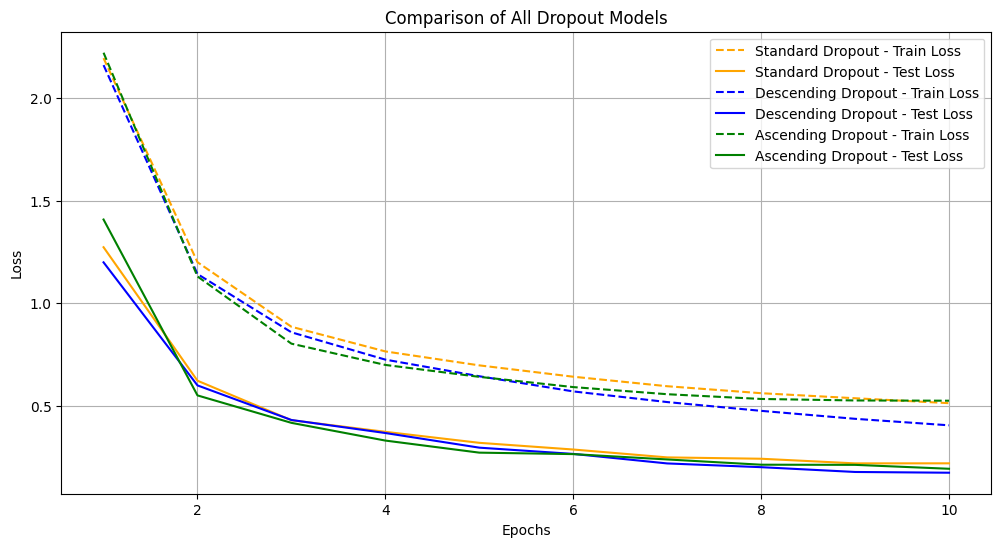

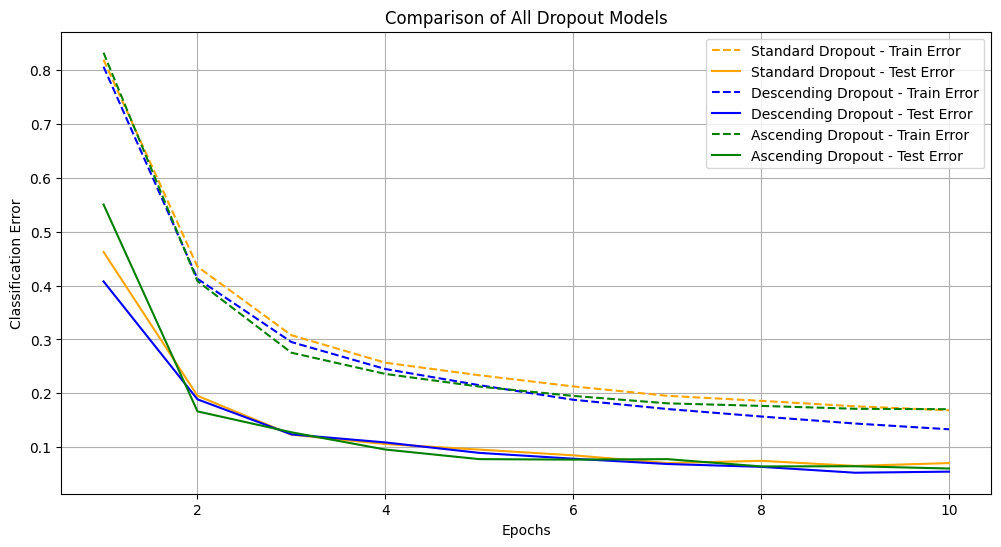

In [11]:
# @title Plot of all the modles
# Plotting the training and test losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Standard Dropout - Train Loss', linestyle='--', color="orange")
plt.plot(range(1, epochs + 1), test_losses, label='Standard Dropout - Test Loss', color="orange")
plt.plot(range(1, epochs + 1), train_losses_ad_des_dr, label='Descending Dropout - Train Loss', linestyle='--', color="blue")
plt.plot(range(1, epochs + 1), test_losses_ad_des_dr, label='Descending Dropout - Test Loss', color="blue")
plt.plot(range(1, epochs + 1), train_losses_ad_asc_dr, label='Ascending Dropout - Train Loss', linestyle='--', color="green")
plt.plot(range(1, epochs + 1), test_losses_ad_asc_dr, label='Ascending Dropout - Test Loss', color="green")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of All Dropout Models')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the training and test errors
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_errors, label='Standard Dropout - Train Error', linestyle='--', color="orange")
plt.plot(range(1, epochs + 1), test_errors, label='Standard Dropout - Test Error', color="orange")
plt.plot(range(1, epochs + 1), train_errors_ad_des_dr, label='Descending Dropout - Train Error', linestyle='--', color="blue")
plt.plot(range(1, epochs + 1), test_errors_ad_des_dr, label='Descending Dropout - Test Error', color="blue")
plt.plot(range(1, epochs + 1), train_errors_ad_asc_dr, label='Ascending Dropout - Train Error', linestyle='--', color="green")
plt.plot(range(1, epochs + 1), test_errors_ad_asc_dr, label='Ascending Dropout - Test Error', color="green")
plt.xlabel('Epochs')
plt.ylabel('Classification Error')
plt.title('Comparison of All Dropout Models')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# @title Compere dropout and addaptive droupout, MLP with Relu and max norm
max_norm_model = MLP(nn.ReLU(), num_inputs=num_features, hidden_layers=2, num_hidden=8192, num_outputs=num_classes).to(device)
ad_des_dr_max_norm_model = ad_dr_MLP(nn.ReLU(), num_inputs=num_features, hidden_layers=2, num_hidden=8192, num_outputs=num_classes).to(device)
ad_asc_dr_max_norm_model = ad_dr_MLP(nn.ReLU(), num_inputs=num_features, hidden_layers=2, num_hidden=8192, num_outputs=num_classes, dropout_start=0.1, dropout_end=0.5).to(device)

# Printing a modules shows all its submodules
print(max_norm_model)
print(ad_des_dr_max_norm_model)
print(ad_asc_dr_max_norm_model)

loss_module=nn.CrossEntropyLoss()
optimizer = optim.SGD(max_norm_model.parameters(), lr=0.01, momentum=0.95)
optimizer_ad_des_dr = optim.SGD(ad_des_dr_max_norm_model.parameters(), lr=0.01, momentum=0.95)
optimizer_ad_asc_dr = optim.SGD(ad_asc_dr_max_norm_model.parameters(), lr=0.01, momentum=0.95)


MLP(
  (dropout_input): Dropout(p=0.8, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=8192, bias=True)
    (1): Linear(in_features=8192, out_features=8192, bias=True)
  )
  (act_fns): ModuleList(
    (0-1): 2 x ReLU()
  )
  (output): Linear(in_features=8192, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
ad_dr_MLP(
  (dropout_input): Dropout(p=0.8, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=8192, bias=True)
    (1): Linear(in_features=8192, out_features=8192, bias=True)
  )
  (act_fns): ModuleList(
    (0-1): 2 x ReLU()
  )
  (output): Linear(in_features=8192, out_features=10, bias=True)
)
ad_dr_MLP(
  (dropout_input): Dropout(p=0.8, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=8192, bias=True)
    (1): Linear(in_features=8192, out_features=8192, bias=True)
  )
  (act_fns): ModuleList(
    (0-1): 2 x ReLU()
  )
  (output): Linear(in_features=

In [14]:
# Lists to store training and test losses and errors
train_losses = []
test_losses = []
train_errors = []
test_errors = []

train_losses_ad_des_dr = []
test_losses_ad_des_dr = []
train_errors_ad_des_dr = []
test_errors_ad_des_dr = []

train_losses_ad_asc_dr = []
test_losses_ad_asc_dr = []
train_errors_ad_asc_dr = []
test_errors_ad_asc_dr = []

# Train and test the model
epochs = 10
for epoch in range(1, epochs + 1):
    train(max_norm_model, trainloader, optimizer, loss_module, epoch)
    test(max_norm_model, testloader, loss_module)

for epoch in range(1, epochs + 1):
    train(ad_des_dr_max_norm_model, trainloader, optimizer_ad_des_dr, loss_module, epoch, ad_dr=True)
    test(ad_des_dr_max_norm_model, testloader, loss_module, ad_dr=True)

for epoch in range(1, epochs + 1):
    train(ad_asc_dr_max_norm_model, trainloader, optimizer_ad_asc_dr, loss_module, epoch, ad_dr=True)
    test(ad_asc_dr_max_norm_model, testloader, loss_module, ad_dr=True)


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.729753
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.320899
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.681627
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.406596
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.607776
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.842996
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.862736
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.517447
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.689729
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.468421

Test set: Average loss: 0.2296, Error: 0.07

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.675550
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.597060
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.558309
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.277496
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.539775
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.710040
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.765545
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.453025
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.418963
Train Epoch: 2 [

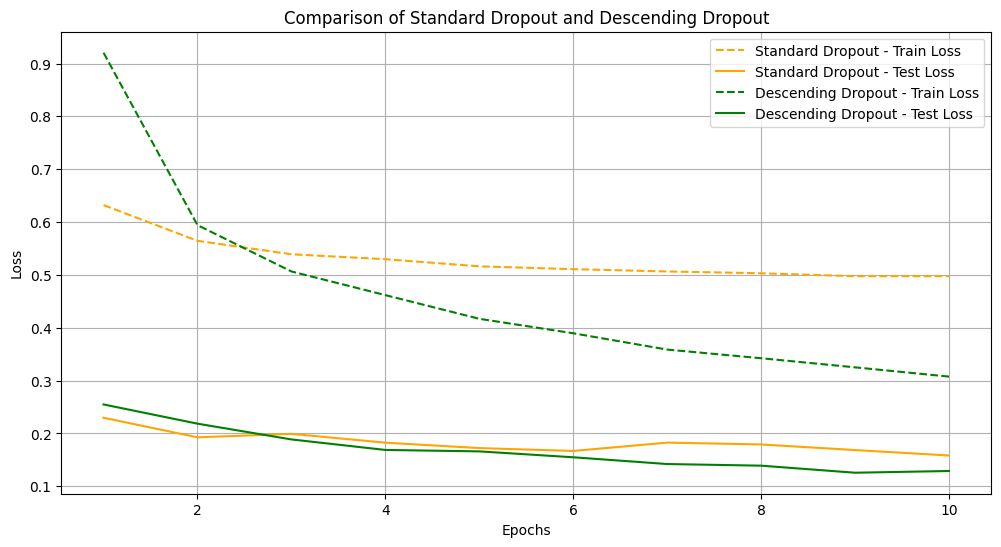

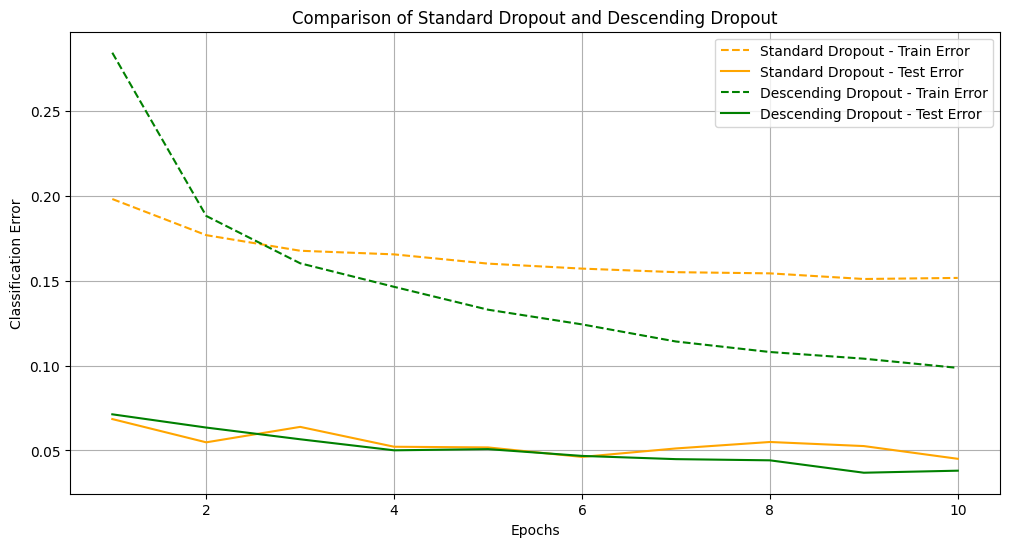

In [15]:
# @title Plots of droupout and desending droupout
# Plotting the training and test losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Standard Dropout - Train Loss', linestyle='--', color="orange")
plt.plot(range(1, epochs + 1), test_losses, label='Standard Dropout - Test Loss', color="orange")
plt.plot(range(1, epochs + 1), train_losses_ad_des_dr, label='Descending Dropout - Train Loss', linestyle='--', color="green")
plt.plot(range(1, epochs + 1), test_losses_ad_des_dr, label='Descending Dropout - Test Loss', color="green")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Standard Dropout and Descending Dropout')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the training and test errors
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_errors, label='Standard Dropout - Train Error', linestyle='--', color="orange")
plt.plot(range(1, epochs + 1), test_errors, label='Standard Dropout - Test Error', color="orange")
plt.plot(range(1, epochs + 1), train_errors_ad_des_dr, label='Descending Dropout - Train Error', linestyle='--', color="green")
plt.plot(range(1, epochs + 1), test_errors_ad_des_dr, label='Descending Dropout - Test Error', color="green")
plt.xlabel('Epochs')
plt.ylabel('Classification Error')
plt.title('Comparison of Standard Dropout and Descending Dropout')
plt.legend()
plt.grid(True)
plt.show()

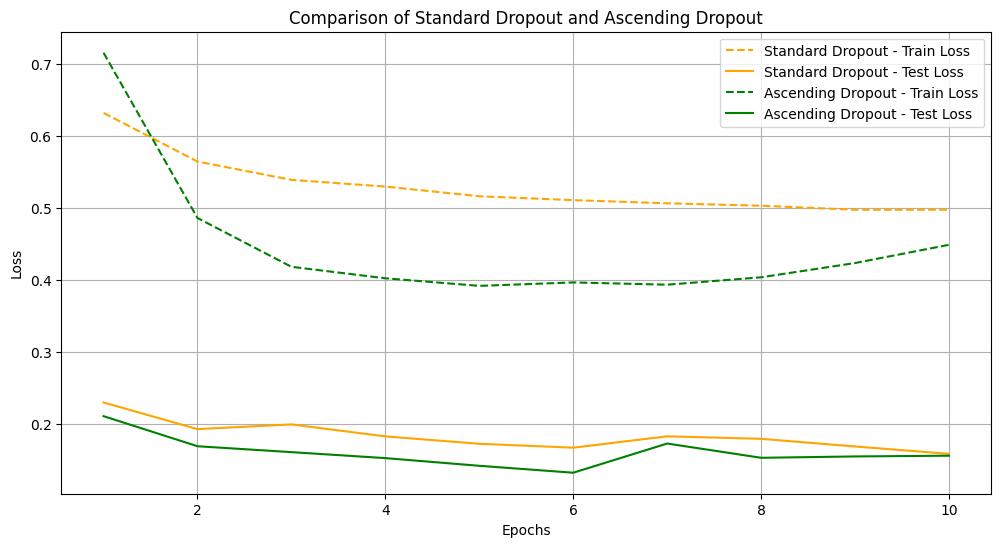

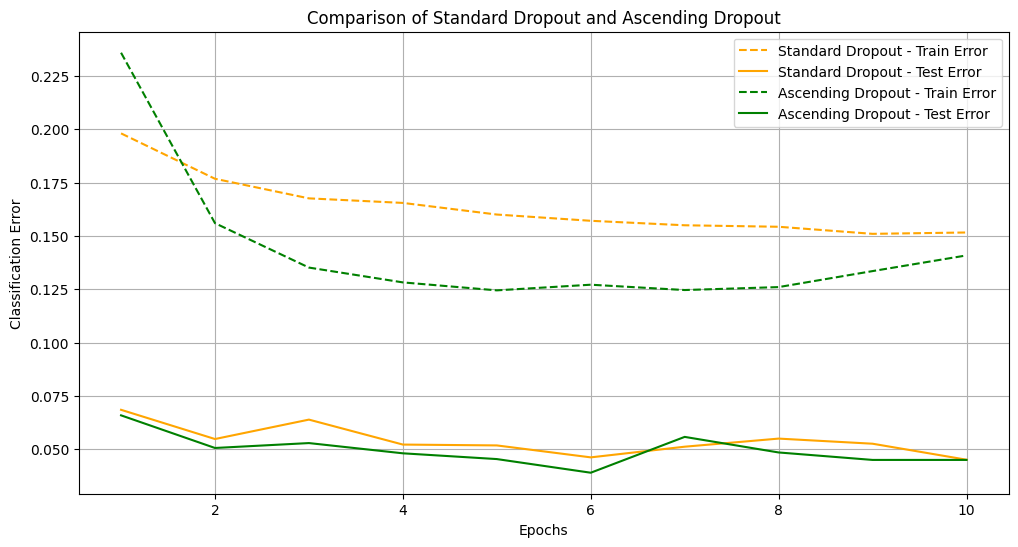

In [16]:
# @title Plots of droupout and ascending droupout
# Plotting the training and test losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Standard Dropout - Train Loss', linestyle='--', color="orange")
plt.plot(range(1, epochs + 1), test_losses, label='Standard Dropout - Test Loss', color="orange")
plt.plot(range(1, epochs + 1), train_losses_ad_asc_dr, label='Ascending Dropout - Train Loss', linestyle='--', color="green")
plt.plot(range(1, epochs + 1), test_losses_ad_asc_dr, label='Ascending Dropout - Test Loss', color="green")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Standard Dropout and Ascending Dropout')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the training and test errors
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_errors, label='Standard Dropout - Train Error', linestyle='--', color="orange")
plt.plot(range(1, epochs + 1), test_errors, label='Standard Dropout - Test Error', color="orange")
plt.plot(range(1, epochs + 1), train_errors_ad_asc_dr, label='Ascending Dropout - Train Error', linestyle='--', color="green")
plt.plot(range(1, epochs + 1), test_errors_ad_asc_dr, label='Ascending Dropout - Test Error', color="green")
plt.xlabel('Epochs')
plt.ylabel('Classification Error')
plt.title('Comparison of Standard Dropout and Ascending Dropout')
plt.legend()
plt.grid(True)
plt.show()


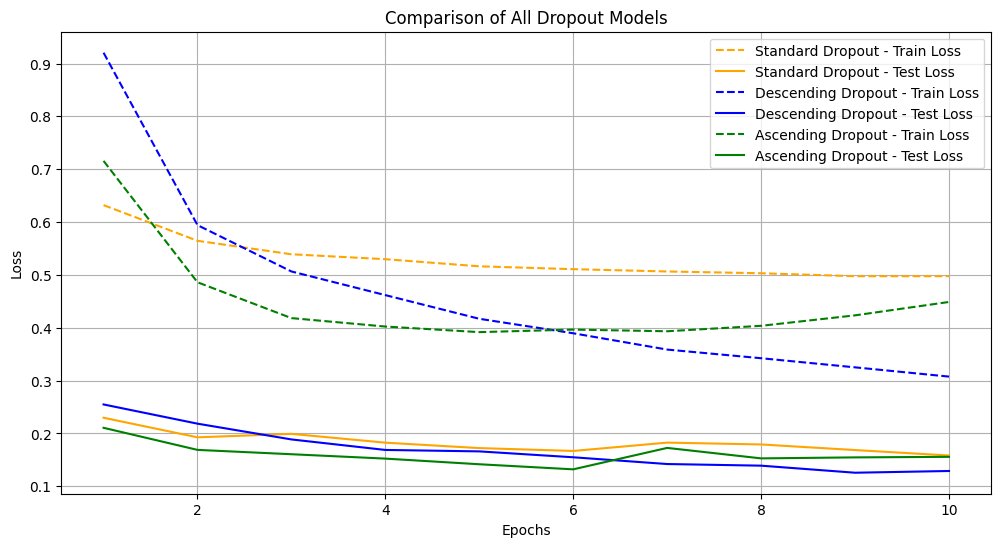

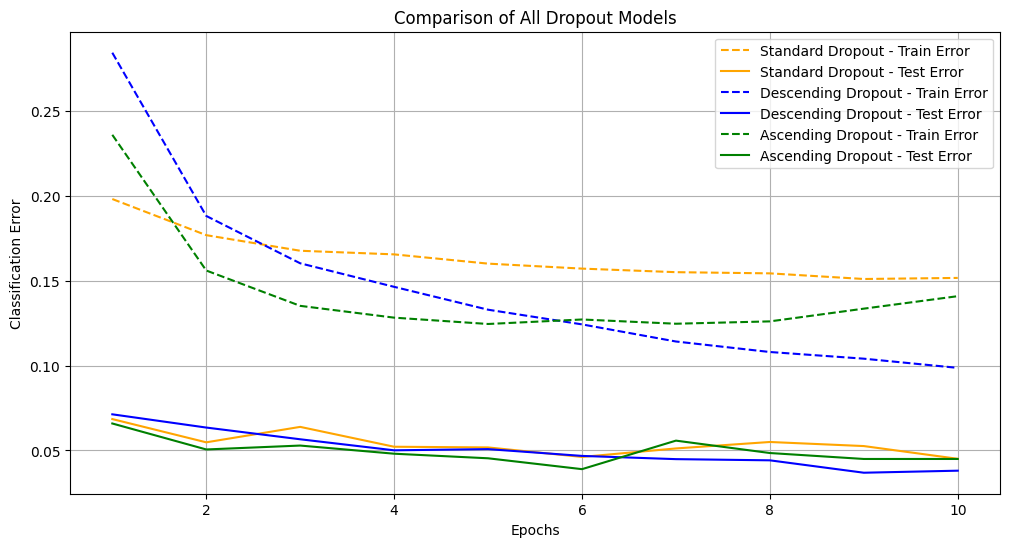

In [17]:
# @title Plot of all the modles
# Plotting the training and test losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Standard Dropout - Train Loss', linestyle='--', color="orange")
plt.plot(range(1, epochs + 1), test_losses, label='Standard Dropout - Test Loss', color="orange")
plt.plot(range(1, epochs + 1), train_losses_ad_des_dr, label='Descending Dropout - Train Loss', linestyle='--', color="blue")
plt.plot(range(1, epochs + 1), test_losses_ad_des_dr, label='Descending Dropout - Test Loss', color="blue")
plt.plot(range(1, epochs + 1), train_losses_ad_asc_dr, label='Ascending Dropout - Train Loss', linestyle='--', color="green")
plt.plot(range(1, epochs + 1), test_losses_ad_asc_dr, label='Ascending Dropout - Test Loss', color="green")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of All Dropout Models')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the training and test errors
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_errors, label='Standard Dropout - Train Error', linestyle='--', color="orange")
plt.plot(range(1, epochs + 1), test_errors, label='Standard Dropout - Test Error', color="orange")
plt.plot(range(1, epochs + 1), train_errors_ad_des_dr, label='Descending Dropout - Train Error', linestyle='--', color="blue")
plt.plot(range(1, epochs + 1), test_errors_ad_des_dr, label='Descending Dropout - Test Error', color="blue")
plt.plot(range(1, epochs + 1), train_errors_ad_asc_dr, label='Ascending Dropout - Train Error', linestyle='--', color="green")
plt.plot(range(1, epochs + 1), test_errors_ad_asc_dr, label='Ascending Dropout - Test Error', color="green")
plt.xlabel('Epochs')
plt.ylabel('Classification Error')
plt.title('Comparison of All Dropout Models')
plt.legend()
plt.grid(True)
plt.show()

# Compre with CIFAR10 dataset


In [18]:
# @title CIFAR10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Print sizes and dimensions
print(f"Training set size: {len(trainset)} samples")
print(f"Test set size: {len(testset)} samples")

# Print number of columns (features) in the dataset
num_features = trainset.data.shape[1] * trainset.data.shape[2] * trainset.data.shape[3]
print(f"Number of columns (features): {num_features}")
# Print number of classes in the dataset
num_classes = len(trainset.classes)
print(f"Number of classes: {num_classes}")

100%|██████████| 170498071/170498071 [00:03<00:00, 47194857.64it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training set size: 50000 samples
Test set size: 10000 samples
Number of columns (features): 3072
Number of classes: 10


In [19]:
# @title Compere dropout and addaptive droupout, MLP with Sigmoid
model = MLP(nn.Sigmoid(), num_inputs=num_features, hidden_layers=3, num_hidden=1024, num_outputs=num_classes).to(device)
ad_des_dr_model = ad_dr_MLP(nn.Sigmoid(), num_inputs=num_features, hidden_layers=3, num_hidden=1024, num_outputs=num_classes).to(device)
ad_asc_dr_model = ad_dr_MLP(nn.Sigmoid(), num_inputs=num_features, hidden_layers=3, num_hidden=1024, num_outputs=num_classes, dropout_start=0.1, dropout_end=0.5).to(device)

# Printing a module shows all its submodules
print(model)
print(ad_des_dr_model)
print(ad_asc_dr_model)

loss_module=nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)
optimizer_ad_des_dr = optim.SGD(ad_des_dr_model.parameters(), lr=0.01, momentum=0.95)
optimizer_ad_asc_dr = optim.SGD(ad_asc_dr_model.parameters(), lr=0.01, momentum=0.95)

MLP(
  (dropout_input): Dropout(p=0.8, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1-2): 2 x Linear(in_features=1024, out_features=1024, bias=True)
  )
  (act_fns): ModuleList(
    (0-2): 3 x Sigmoid()
  )
  (output): Linear(in_features=1024, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
ad_dr_MLP(
  (dropout_input): Dropout(p=0.8, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1-2): 2 x Linear(in_features=1024, out_features=1024, bias=True)
  )
  (act_fns): ModuleList(
    (0-2): 3 x Sigmoid()
  )
  (output): Linear(in_features=1024, out_features=10, bias=True)
)
ad_dr_MLP(
  (dropout_input): Dropout(p=0.8, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1-2): 2 x Linear(in_features=1024, out_features=1024, bias=True)
  )
  (act_fns): ModuleList(
    (0-2): 3 x Sigmoid()
  )
 

In [20]:
# Lists to store training and test losses and errors
train_losses = []
test_losses = []
train_errors = []
test_errors = []

train_losses_ad_des_dr = []
test_losses_ad_des_dr = []
train_errors_ad_des_dr = []
test_errors_ad_des_dr = []

train_losses_ad_asc_dr = []
test_losses_ad_asc_dr = []
train_errors_ad_asc_dr = []
test_errors_ad_asc_dr = []


# Train and test the models
epochs = 10
for epoch in range(1, epochs + 1):
    train(model, trainloader, optimizer, loss_module, epoch)
    test(model, testloader, loss_module)

for epoch in range(1, epochs + 1):
    train(ad_des_dr_model, trainloader, optimizer_ad_des_dr, loss_module, epoch, ad_dr=True)
    test(ad_des_dr_model, testloader, loss_module, ad_dr=True)

for epoch in range(1, epochs + 1):
    train(ad_asc_dr_model, trainloader, optimizer_ad_asc_dr, loss_module, epoch, ad_dr=True)
    test(ad_asc_dr_model, testloader, loss_module, ad_dr=True)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.372375
Train Epoch: 1 [10000/50000 (20%)]	Loss: 2.508070
Train Epoch: 1 [20000/50000 (40%)]	Loss: 2.315422
Train Epoch: 1 [30000/50000 (60%)]	Loss: 2.358741
Train Epoch: 1 [40000/50000 (80%)]	Loss: 2.328491

Test set: Average loss: 2.3035, Error: 0.84

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.303105
Train Epoch: 2 [10000/50000 (20%)]	Loss: 2.295579
Train Epoch: 2 [20000/50000 (40%)]	Loss: 2.256144
Train Epoch: 2 [30000/50000 (60%)]	Loss: 2.220090
Train Epoch: 2 [40000/50000 (80%)]	Loss: 2.115127

Test set: Average loss: 2.0870, Error: 0.81

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.156367
Train Epoch: 3 [10000/50000 (20%)]	Loss: 2.114502
Train Epoch: 3 [20000/50000 (40%)]	Loss: 2.048259
Train Epoch: 3 [30000/50000 (60%)]	Loss: 2.137035
Train Epoch: 3 [40000/50000 (80%)]	Loss: 2.234884

Test set: Average loss: 2.0594, Error: 0.80

Train Epoch: 4 [0/50000 (0%)]	Loss: 2.084800
Train Epoch: 4 [10000/50000 (20%)]	Loss: 2.102608
Train Epoch: 4 [20000/50000 (40%

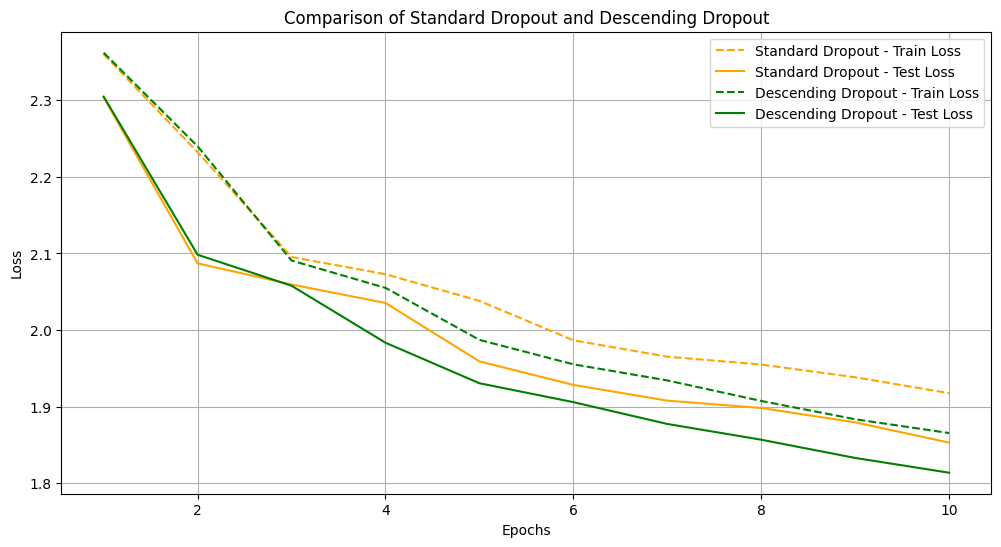

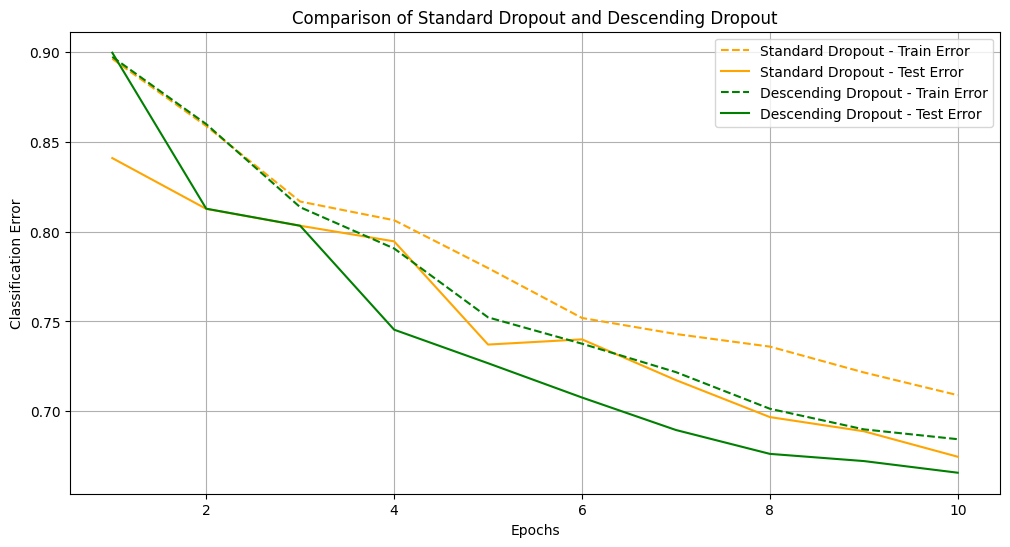

In [21]:
# @title Plots of droupout and desending droupout
# Plotting the training and test losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Standard Dropout - Train Loss', linestyle='--', color="orange")
plt.plot(range(1, epochs + 1), test_losses, label='Standard Dropout - Test Loss', color="orange")
plt.plot(range(1, epochs + 1), train_losses_ad_des_dr, label='Descending Dropout - Train Loss', linestyle='--', color="green")
plt.plot(range(1, epochs + 1), test_losses_ad_des_dr, label='Descending Dropout - Test Loss', color="green")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Standard Dropout and Descending Dropout')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the training and test errors
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_errors, label='Standard Dropout - Train Error', linestyle='--', color="orange")
plt.plot(range(1, epochs + 1), test_errors, label='Standard Dropout - Test Error', color="orange")
plt.plot(range(1, epochs + 1), train_errors_ad_des_dr, label='Descending Dropout - Train Error', linestyle='--', color="green")
plt.plot(range(1, epochs + 1), test_errors_ad_des_dr, label='Descending Dropout - Test Error', color="green")
plt.xlabel('Epochs')
plt.ylabel('Classification Error')
plt.title('Comparison of Standard Dropout and Descending Dropout')
plt.legend()
plt.grid(True)
plt.show()

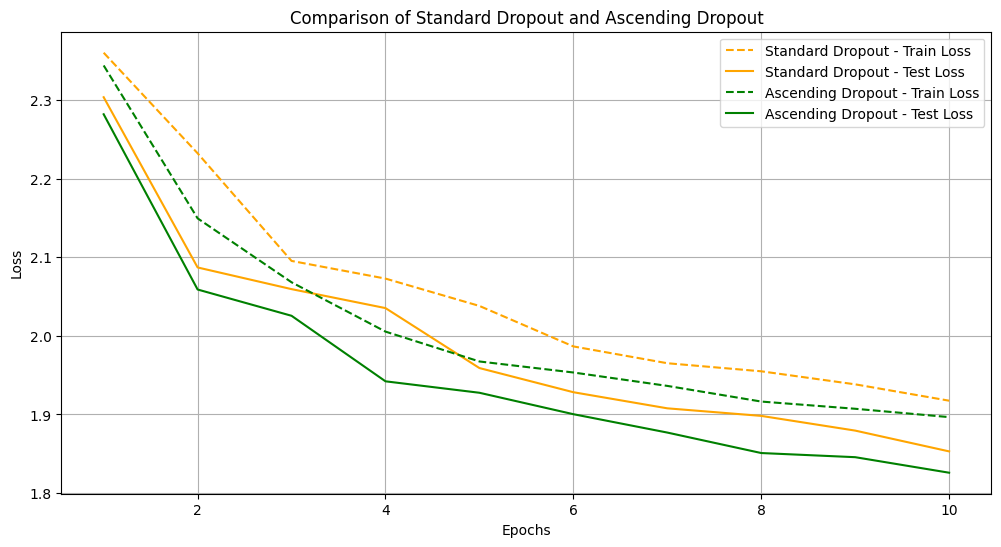

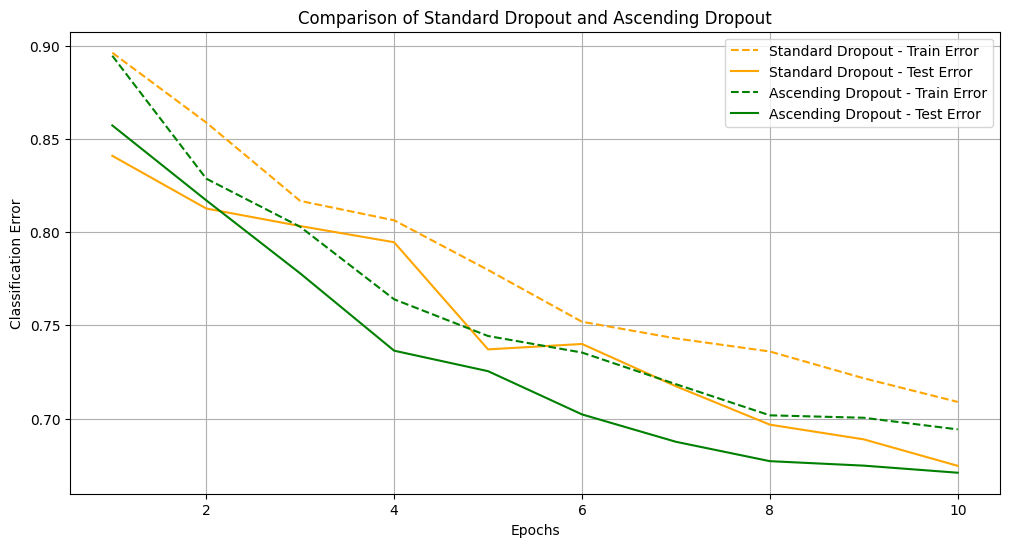

In [22]:
# @title Plots of droupout and ascending droupout
# Plotting the training and test losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Standard Dropout - Train Loss', linestyle='--', color="orange")
plt.plot(range(1, epochs + 1), test_losses, label='Standard Dropout - Test Loss', color="orange")
plt.plot(range(1, epochs + 1), train_losses_ad_asc_dr, label='Ascending Dropout - Train Loss', linestyle='--', color="green")
plt.plot(range(1, epochs + 1), test_losses_ad_asc_dr, label='Ascending Dropout - Test Loss', color="green")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Standard Dropout and Ascending Dropout')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the training and test errors
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_errors, label='Standard Dropout - Train Error', linestyle='--', color="orange")
plt.plot(range(1, epochs + 1), test_errors, label='Standard Dropout - Test Error', color="orange")
plt.plot(range(1, epochs + 1), train_errors_ad_asc_dr, label='Ascending Dropout - Train Error', linestyle='--', color="green")
plt.plot(range(1, epochs + 1), test_errors_ad_asc_dr, label='Ascending Dropout - Test Error', color="green")
plt.xlabel('Epochs')
plt.ylabel('Classification Error')
plt.title('Comparison of Standard Dropout and Ascending Dropout')
plt.legend()
plt.grid(True)
plt.show()


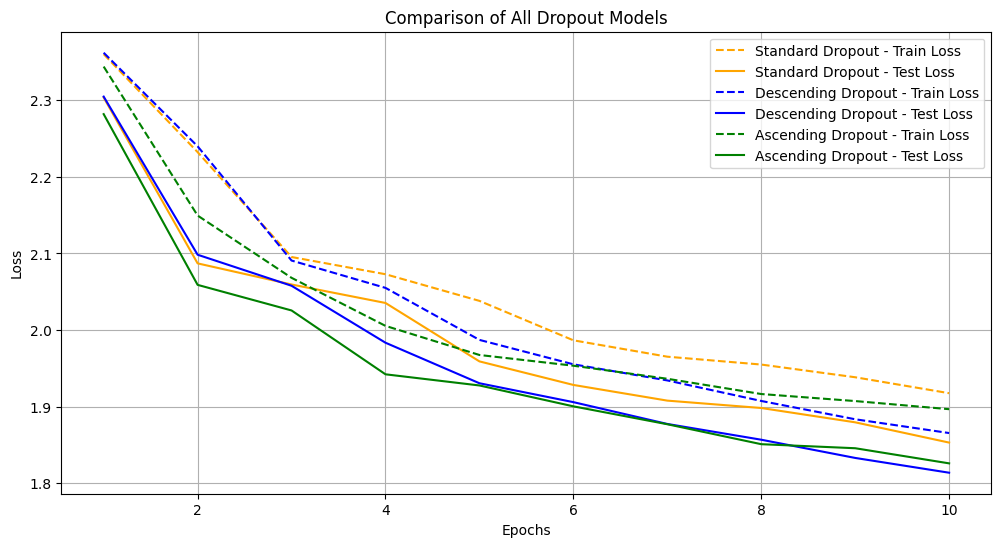

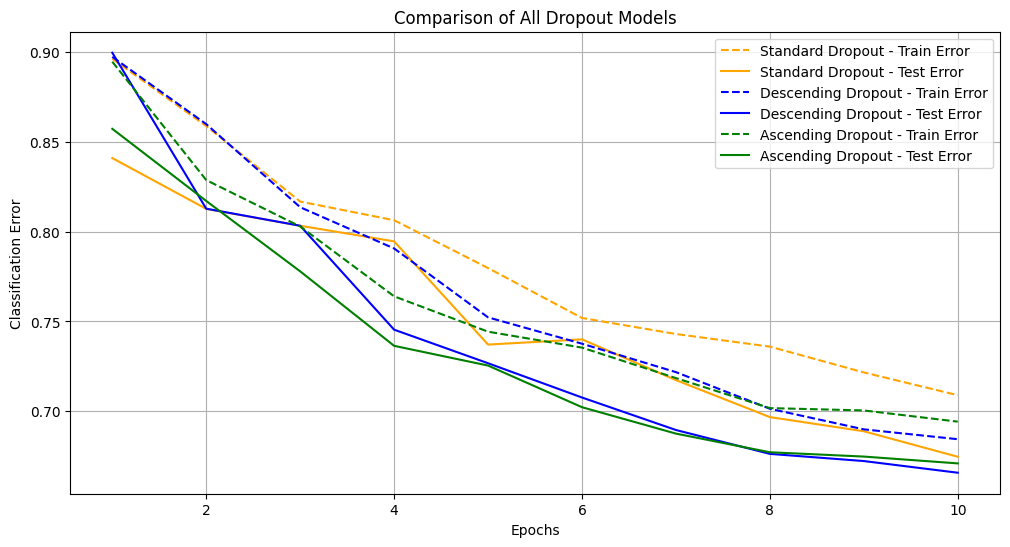

In [23]:
# @title Plot of all the modles
# Plotting the training and test losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Standard Dropout - Train Loss', linestyle='--', color="orange")
plt.plot(range(1, epochs + 1), test_losses, label='Standard Dropout - Test Loss', color="orange")
plt.plot(range(1, epochs + 1), train_losses_ad_des_dr, label='Descending Dropout - Train Loss', linestyle='--', color="blue")
plt.plot(range(1, epochs + 1), test_losses_ad_des_dr, label='Descending Dropout - Test Loss', color="blue")
plt.plot(range(1, epochs + 1), train_losses_ad_asc_dr, label='Ascending Dropout - Train Loss', linestyle='--', color="green")
plt.plot(range(1, epochs + 1), test_losses_ad_asc_dr, label='Ascending Dropout - Test Loss', color="green")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of All Dropout Models')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the training and test errors
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_errors, label='Standard Dropout - Train Error', linestyle='--', color="orange")
plt.plot(range(1, epochs + 1), test_errors, label='Standard Dropout - Test Error', color="orange")
plt.plot(range(1, epochs + 1), train_errors_ad_des_dr, label='Descending Dropout - Train Error', linestyle='--', color="blue")
plt.plot(range(1, epochs + 1), test_errors_ad_des_dr, label='Descending Dropout - Test Error', color="blue")
plt.plot(range(1, epochs + 1), train_errors_ad_asc_dr, label='Ascending Dropout - Train Error', linestyle='--', color="green")
plt.plot(range(1, epochs + 1), test_errors_ad_asc_dr, label='Ascending Dropout - Test Error', color="green")
plt.xlabel('Epochs')
plt.ylabel('Classification Error')
plt.title('Comparison of All Dropout Models')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# @title Compere dropout and addaptive droupout, MLP with Relu and max norm
max_norm_model = MLP(nn.ReLU(), num_inputs=num_features, hidden_layers=2, num_hidden=8192, num_outputs=num_classes).to(device)
ad_des_dr_max_norm_model = ad_dr_MLP(nn.ReLU(), num_inputs=num_features, hidden_layers=2, num_hidden=8192, num_outputs=num_classes).to(device)
ad_asc_dr_max_norm_model = ad_dr_MLP(nn.ReLU(), num_inputs=num_features, hidden_layers=2, num_hidden=8192, num_outputs=num_classes, dropout_start=0.1, dropout_end=0.5).to(device)

# Printing a modules shows all its submodules
print(max_norm_model)
print(ad_des_dr_max_norm_model)
print(ad_asc_dr_max_norm_model)

loss_module=nn.CrossEntropyLoss()
optimizer = optim.SGD(max_norm_model.parameters(), lr=0.01, momentum=0.95)
optimizer_ad_des_dr = optim.SGD(ad_des_dr_max_norm_model.parameters(), lr=0.01, momentum=0.95)
optimizer_ad_asc_dr = optim.SGD(ad_asc_dr_max_norm_model.parameters(), lr=0.01, momentum=0.95)


MLP(
  (dropout_input): Dropout(p=0.8, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=3072, out_features=8192, bias=True)
    (1): Linear(in_features=8192, out_features=8192, bias=True)
  )
  (act_fns): ModuleList(
    (0-1): 2 x ReLU()
  )
  (output): Linear(in_features=8192, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
ad_dr_MLP(
  (dropout_input): Dropout(p=0.8, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=3072, out_features=8192, bias=True)
    (1): Linear(in_features=8192, out_features=8192, bias=True)
  )
  (act_fns): ModuleList(
    (0-1): 2 x ReLU()
  )
  (output): Linear(in_features=8192, out_features=10, bias=True)
)
ad_dr_MLP(
  (dropout_input): Dropout(p=0.8, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=3072, out_features=8192, bias=True)
    (1): Linear(in_features=8192, out_features=8192, bias=True)
  )
  (act_fns): ModuleList(
    (0-1): 2 x ReLU()
  )
  (output): Linear(in_featur

In [25]:
# Lists to store training and test losses and errors
train_losses = []
test_losses = []
train_errors = []
test_errors = []

train_losses_ad_des_dr = []
test_losses_ad_des_dr = []
train_errors_ad_des_dr = []
test_errors_ad_des_dr = []

train_losses_ad_asc_dr = []
test_losses_ad_asc_dr = []
train_errors_ad_asc_dr = []
test_errors_ad_asc_dr = []


# Train and test the model
epochs = 10
for epoch in range(1, epochs + 1):
    train(max_norm_model, trainloader, optimizer, loss_module, epoch)
    test(max_norm_model, testloader, loss_module)

for epoch in range(1, epochs + 1):
    train(ad_des_dr_max_norm_model, trainloader, optimizer_ad_des_dr, loss_module, epoch, ad_dr=True)
    test(ad_des_dr_max_norm_model, testloader, loss_module, ad_dr=True)

for epoch in range(1, epochs + 1):
    train(ad_asc_dr_max_norm_model, trainloader, optimizer_ad_asc_dr, loss_module, epoch, ad_dr=True)
    test(ad_asc_dr_max_norm_model, testloader, loss_module, ad_dr=True)


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.319043
Train Epoch: 1 [10000/50000 (20%)]	Loss: 1.968841
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.745375
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.956495
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.830066

Test set: Average loss: 1.7175, Error: 0.61

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.948393
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.874028
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.779494
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.763706
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.708540

Test set: Average loss: 1.6434, Error: 0.57

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.817287
Train Epoch: 3 [10000/50000 (20%)]	Loss: 1.899344
Train Epoch: 3 [20000/50000 (40%)]	Loss: 1.849087
Train Epoch: 3 [30000/50000 (60%)]	Loss: 1.777005
Train Epoch: 3 [40000/50000 (80%)]	Loss: 1.891379

Test set: Average loss: 1.5938, Error: 0.56

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.768014
Train Epoch: 4 [10000/50000 (20%)]	Loss: 1.516595
Train Epoch: 4 [20000/50000 (40%

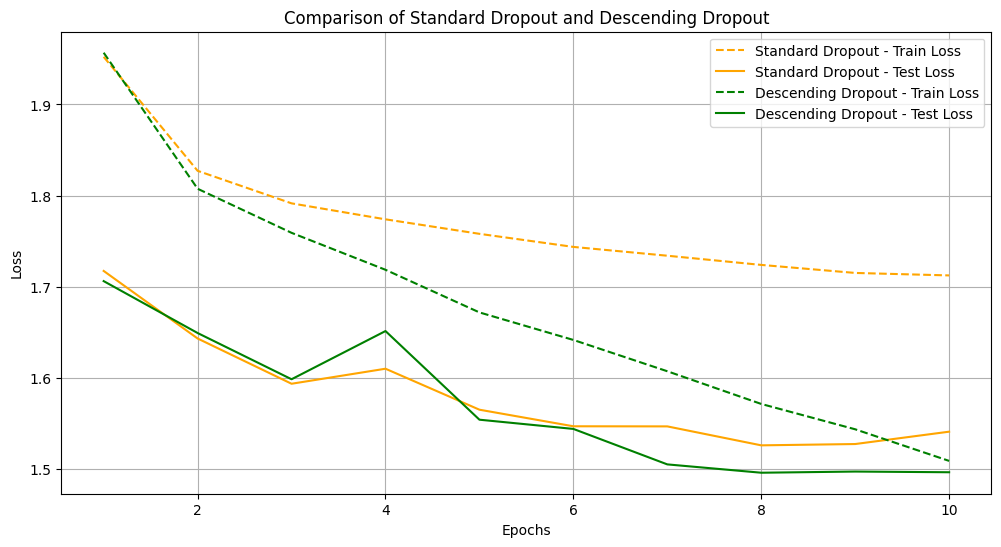

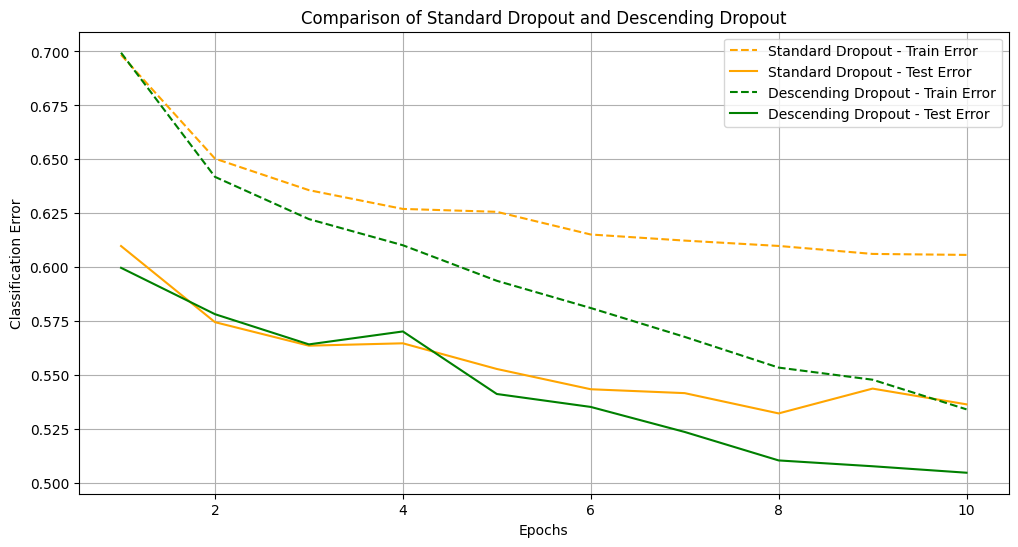

In [26]:
# @title Plots of droupout and desending droupout
# Plotting the training and test losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Standard Dropout - Train Loss', linestyle='--', color="orange")
plt.plot(range(1, epochs + 1), test_losses, label='Standard Dropout - Test Loss', color="orange")
plt.plot(range(1, epochs + 1), train_losses_ad_des_dr, label='Descending Dropout - Train Loss', linestyle='--', color="green")
plt.plot(range(1, epochs + 1), test_losses_ad_des_dr, label='Descending Dropout - Test Loss', color="green")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Standard Dropout and Descending Dropout')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the training and test errors
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_errors, label='Standard Dropout - Train Error', linestyle='--', color="orange")
plt.plot(range(1, epochs + 1), test_errors, label='Standard Dropout - Test Error', color="orange")
plt.plot(range(1, epochs + 1), train_errors_ad_des_dr, label='Descending Dropout - Train Error', linestyle='--', color="green")
plt.plot(range(1, epochs + 1), test_errors_ad_des_dr, label='Descending Dropout - Test Error', color="green")
plt.xlabel('Epochs')
plt.ylabel('Classification Error')
plt.title('Comparison of Standard Dropout and Descending Dropout')
plt.legend()
plt.grid(True)
plt.show()

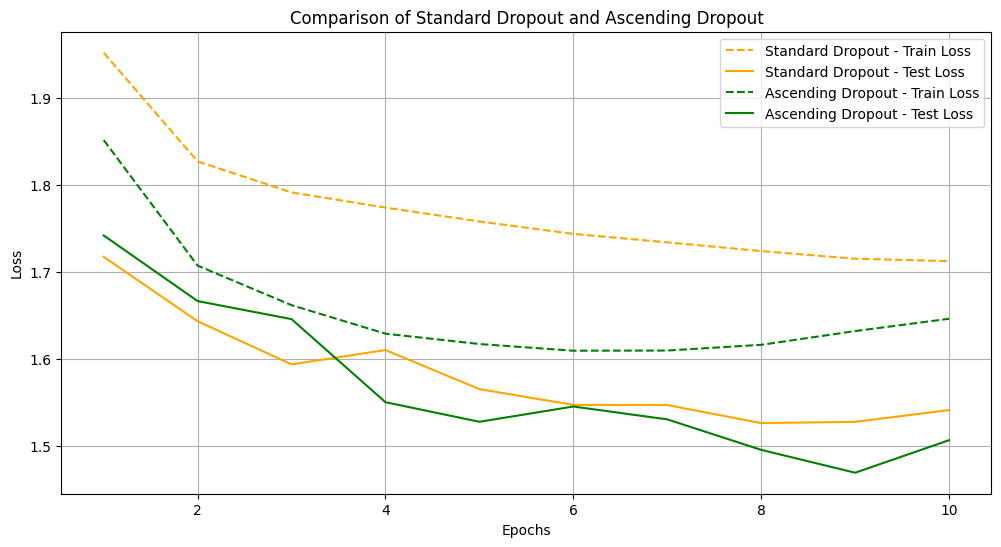

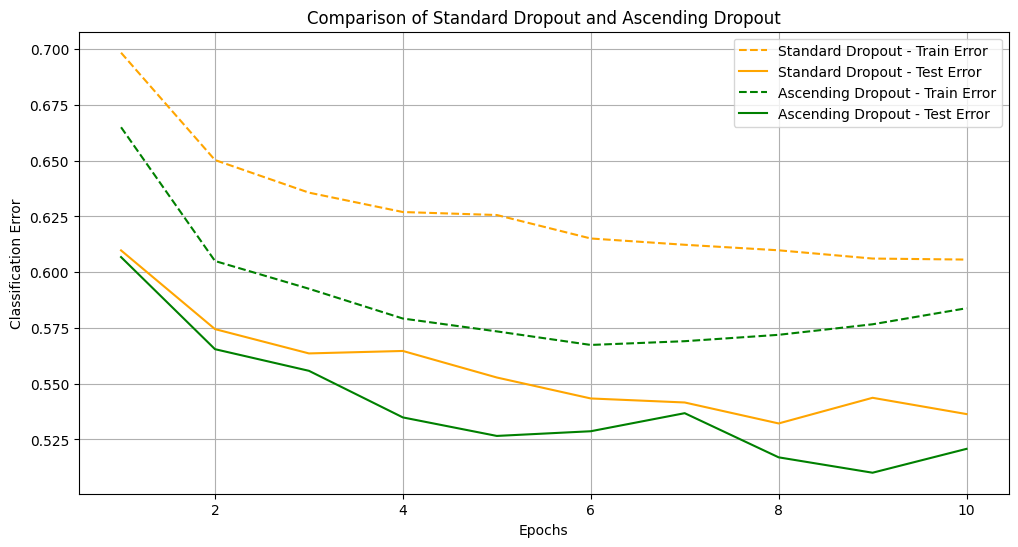

In [27]:
# @title Plots of droupout and ascending droupout
# Plotting the training and test losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Standard Dropout - Train Loss', linestyle='--', color="orange")
plt.plot(range(1, epochs + 1), test_losses, label='Standard Dropout - Test Loss', color="orange")
plt.plot(range(1, epochs + 1), train_losses_ad_asc_dr, label='Ascending Dropout - Train Loss', linestyle='--', color="green")
plt.plot(range(1, epochs + 1), test_losses_ad_asc_dr, label='Ascending Dropout - Test Loss', color="green")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Standard Dropout and Ascending Dropout')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the training and test errors
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_errors, label='Standard Dropout - Train Error', linestyle='--', color="orange")
plt.plot(range(1, epochs + 1), test_errors, label='Standard Dropout - Test Error', color="orange")
plt.plot(range(1, epochs + 1), train_errors_ad_asc_dr, label='Ascending Dropout - Train Error', linestyle='--', color="green")
plt.plot(range(1, epochs + 1), test_errors_ad_asc_dr, label='Ascending Dropout - Test Error', color="green")
plt.xlabel('Epochs')
plt.ylabel('Classification Error')
plt.title('Comparison of Standard Dropout and Ascending Dropout')
plt.legend()
plt.grid(True)
plt.show()


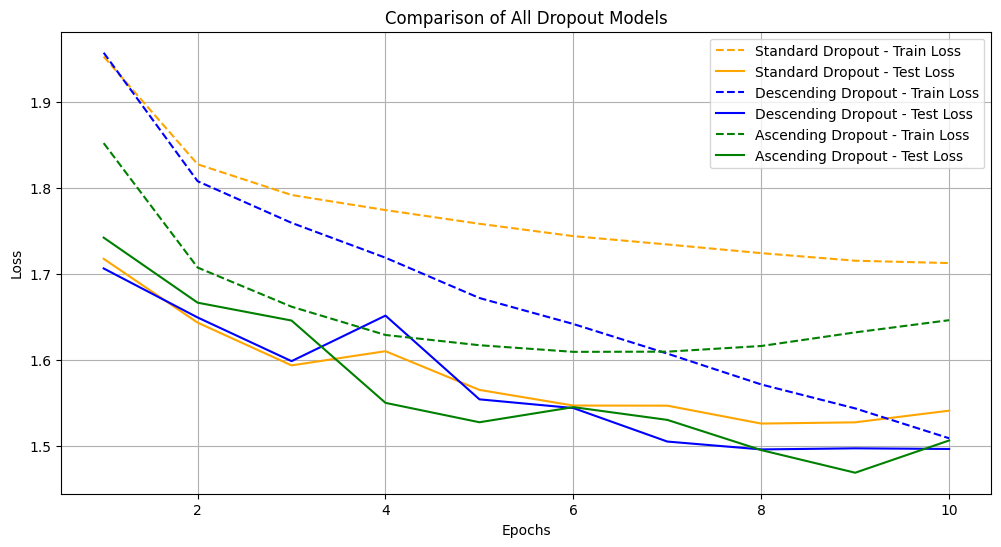

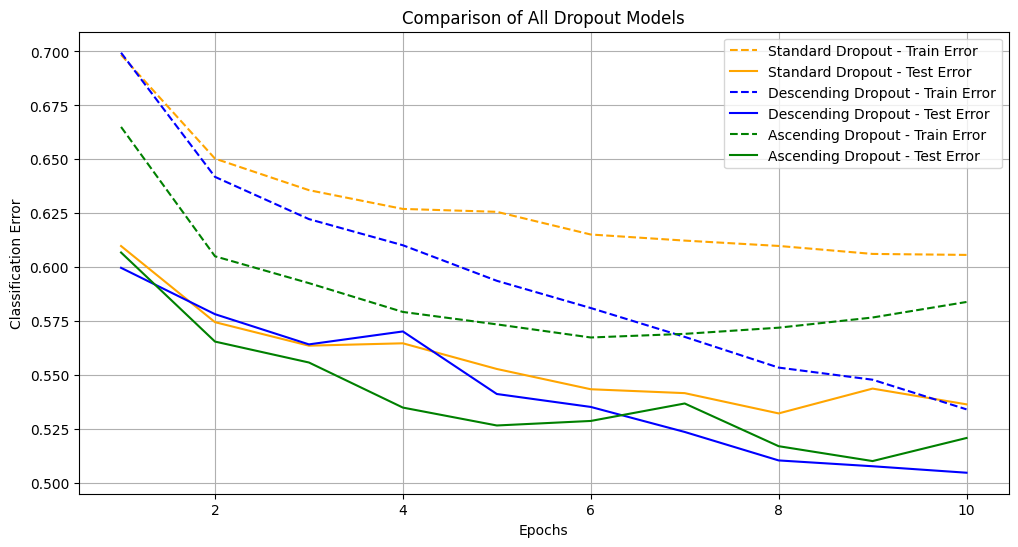

In [28]:
# @title Plot of all the modles
# Plotting the training and test losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Standard Dropout - Train Loss', linestyle='--', color="orange")
plt.plot(range(1, epochs + 1), test_losses, label='Standard Dropout - Test Loss', color="orange")
plt.plot(range(1, epochs + 1), train_losses_ad_des_dr, label='Descending Dropout - Train Loss', linestyle='--', color="blue")
plt.plot(range(1, epochs + 1), test_losses_ad_des_dr, label='Descending Dropout - Test Loss', color="blue")
plt.plot(range(1, epochs + 1), train_losses_ad_asc_dr, label='Ascending Dropout - Train Loss', linestyle='--', color="green")
plt.plot(range(1, epochs + 1), test_losses_ad_asc_dr, label='Ascending Dropout - Test Loss', color="green")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of All Dropout Models')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the training and test errors
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_errors, label='Standard Dropout - Train Error', linestyle='--', color="orange")
plt.plot(range(1, epochs + 1), test_errors, label='Standard Dropout - Test Error', color="orange")
plt.plot(range(1, epochs + 1), train_errors_ad_des_dr, label='Descending Dropout - Train Error', linestyle='--', color="blue")
plt.plot(range(1, epochs + 1), test_errors_ad_des_dr, label='Descending Dropout - Test Error', color="blue")
plt.plot(range(1, epochs + 1), train_errors_ad_asc_dr, label='Ascending Dropout - Train Error', linestyle='--', color="green")
plt.plot(range(1, epochs + 1), test_errors_ad_asc_dr, label='Ascending Dropout - Test Error', color="green")
plt.xlabel('Epochs')
plt.ylabel('Classification Error')
plt.title('Comparison of All Dropout Models')
plt.legend()
plt.grid(True)
plt.show()